### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> 🧬 Notesbook at a Glance</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import re as re
from collections import Counter
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier

import seaborn as sns
from tqdm.auto import tqdm
import math
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
import warnings

import time
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
tqdm.pandas()


In [3]:
train = pd.read_csv('playground-series-s3e18/train.csv')
test = pd.read_csv('playground-series-s3e18/test.csv')
sub=pd.read_csv('playground-series-s3e18/sample_submission.csv')

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300"> 🧬 Brief EDA</p>

In [ ]:
# summary table function
pd.options.display.float_format = '{:,.2f}'.format
def summary(df):
    print(f'data shape: {df.shape}')
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values 
    summ['%missing'] = df.isnull().sum().values / len(df) * 100
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['average'] = desc['mean'].values
    summ['standard_deviation'] = desc['std'].values
    summ['first value'] = df.loc[0].values
    summ['second value'] = df.loc[1].values
    summ['third value'] = df.loc[2].values
    
    return summ

In [ ]:
summary(train).style.background_gradient(cmap='YlOrBr')

In [ ]:
#let's check the label variables.

# Define the labels
labels = ['EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']

# Count the number of 1s in each class
counts = [train[label].sum() for label in labels]

# Create the bar plot
plt.figure(figsize=(10,6))
plt.bar(labels, counts, color='skyblue')
plt.title('Number of 1s in Each Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 About Dataset:</font></h3>

<ul>
    <li><b>Data Size</b>: The dataset contains 14,838 rows and 38 columns.</li>
    <li><b>Data Types</b>: The data contains features with data types int64 and float64.</li>
    <li><b>Missing Values</b>: No column has missing values in the dataset, which is a great sign and simplifies the data cleaning process.</li>
    <li><b>Unique Values</b>: The number of unique values varies greatly among features, with some features like 'id' having unique values for each entry and others like 'EC1', 'EC2', etc., having only two unique values. This suggests a mix of categorical and continuous variables.</li>
    <li><b>Statistical Details</b>: The 'min', 'max', 'average', and 'standard deviation' values indicate the range and dispersion of data for each column, highlighting potential outliers or anomalies.</li>
    <li><b>Irrelevant Features</b>: The 'id' column, as a unique identifier, may not provide meaningful insights for analysis and could potentially be dropped.</li>
    <li><b>Multi-label Classification</b>: This dataset poses a multi-label classification task with 'EC1' through 'EC6' serving as labels. Each of these columns represents a different class to predict, with values of either 0 or 1. Importantly, multiple labels can be true simultaneously. For instance, a data point could have both 'EC1' and 'EC2' as 1, indicating that it belongs to both classes.</li>
</ul>

This summary offers a comprehensive initial understanding of the dataset's characteristics, helping to inform subsequent steps in your data analysis process.
</div>





<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#DEB887'>💡 About Features:</font></h3>
<ul>
    <li><b>BertzCT</b>: Bertz counter (Topological Charge Transfer) value associated with the structural complexity of the molecule.</li>
    <li><b>Chi1, Chi1n, Chi1v</b>: Kier's First-order Molecular Connectivity Index, representing the molecular surface area.</li>
    <li><b>Chi2n, Chi2v, Chi3v</b>: Kier's Second-order and Third-order Connectivity Index, representing the 2nd and 3rd degree connectivity of the molecule.</li>
    <li><b>Chi4n</b>: Kier's Fourth-order Connectivity Index, representing the 4th degree connectivity of the molecule.</li>
    <li><b>EState_VSA1, EState_VSA2</b>: EState-VSA (E-State Value Sum) 1 and 2, representing the electrotopological state contributions of the molecule.</li>
    <li><b>ExactMolWt</b>: Exact molecular weight of the molecule.</li>
    <li><b>FpDensityMorgan1, FpDensityMorgan2, FpDensityMorgan3</b>: Density values of the Morgan fingerprint.</li>
    <li><b>HallKierAlpha</b>: Hall-Kier Alpha value of the molecule, describing its core structure.</li>
    <li><b>HeavyAtomMolWt</b>: Molecular weight of atoms in the molecule, excluding hydrogen atoms.</li>
    <li><b>Kappa3</b>: Kappa-3 shape index of the molecule, describing its topology.</li>
    <li><b>MaxAbsEStateIndex</b>: Maximum absolute E-State index of the molecule, representing its maximum charge state.</li>
    <li><b>MinEStateIndex</b>: Minimum E-State index of the molecule, representing its minimum charge state.</li>
    <li><b>NumHeteroatoms</b>: Number of heteroatoms (non-carbon atoms) in the molecule.</li>
    <li><b>PEOE_VSA10, PEOE_VSA14, PEOE_VSA6, PEOE_VSA7, PEOE_VSA8</b>: PEOE (Partial Equalization of Orbital Electronegativity) VSA (Value Sum) 10, 14, 6, 7, 8, representing the partial charge surface area contributions of the molecule.</li>
    <li><b>SMR_VSA10, SMR_VSA5</b>: SMR (Simple Molecular Representation) VSA 10, 5, representing the similarity model radius surface area contributions of the molecule.</li>
    <li><b>SlogP_VSA3</b>: SlogP (Substructure-logP) VSA 3, representing the logarithm of the partition coefficient of the molecule.</li>
    <li><b>VSA_EState9</b>: E-State-VSA (E-State Value Sum) 9, representing the electrotopological state contributions of the molecule related to its surface area.</li>
    <li><b>fr_COO, fr_COO2</b>: Number of carboxyl groups in the molecule.</li>
</ul>

In [4]:
# Column names in the DataFrame
columns = list(train.columns)

# Remove 'EC1' to 'EC6' and 'id'
features = [col for col in columns if col not in ['id', 'EC1', 'EC2', 'EC3', 'EC4', 'EC5', 'EC6']]

print(features)


['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n', 'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha', 'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex', 'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9', 'fr_COO', 'fr_COO2']


In [ ]:
plt.figure(figsize=(14,20))

for idx,column in enumerate(features[:10]):
    # Plotting for 'EC1'
    plt.subplot(10,2,idx*2+1)
    sns.histplot(x=column, hue="EC1", data=train,bins=30,kde=True,palette='YlOrRd')
    plt.title(f"{column} Distribution for EC1")
    plt.ylim(0,100)
    plt.tight_layout()
    
    # Plotting for 'EC2'
    plt.subplot(10,2,idx*2+2)
    sns.histplot(x=column, hue="EC2", data=train,bins=30,kde=True,palette='YlOrRd')
    plt.title(f"{column} Distribution for EC2")
    plt.ylim(0,100)
    plt.tight_layout()


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* The main point is that if the distributions of 'EC1' and 'EC2' are significantly different, this feature could be useful in predicting the class. Although most of them appear to be similar, it can be observed that variables like 'EState_VSA1' are very different. Only 10 features were selected and examined due to the large number of features.

In [ ]:
def plot_correlation_heatmap(df: pd.core.frame.DataFrame, title_name: str = 'Train correlation') -> None:
    # create excluded list
    excluded_columns = ['id', 'EC3', 'EC4', 'EC5', 'EC6']
    
    # Create a list of columns excluding the excluded_columns.
    columns_without_excluded = [col for col in df.columns if col not in excluded_columns]
    
    corr = df[columns_without_excluded].corr()
    fig, axes = plt.subplots(figsize=(14, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask=mask, linewidths=.5, cmap='YlOrBr_r', annot=True, annot_kws={"size": 6})
    plt.title(title_name)
    plt.show()

plot_correlation_heatmap(train[columns], 'Train Dataset Correlation')



<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* 
When examining the correlation plot, it is evident that many variables exhibit high correlations. However, it is crucial to exercise caution as the interpretation of "high" or "low" correlation can vary across different domains. It is worth noting that in the context of enzyme data, it is commonly observed for variables to demonstrate higher correlations. However, it is important to consider additional perspectives and domain-specific knowledge to accurately assess the significance of these correlations. Drawing conclusions based solely on correlation values may lead to misleading interpretations. Therefore, a comprehensive analysis that takes into account various factors is necessary to gain a deeper understanding of the data and make meaningful inferences.

### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🔩 basic feature engineering and baseline modeling</p>

<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#DEB887'>💡 About modeling:</font></h3>
The difference between multi-label classification and multi-class classification is as follows:
<br><br>
<b>Multi-label Classification:</b><br> Multi-label classification deals with scenarios where each data instance can be assigned to multiple labels or classes. This means that a single data point can belong to multiple classes simultaneously. For example, in image classification, an image may contain multiple objects, and the task is to recognize and classify all of these objects simultaneously. This problem is tackled using multi-label classification.
<br><br>
<b>Multi-class Classification:</b><br> Multi-class classification, on the other hand, deals with scenarios where each data instance can be assigned to only one class out of several possible classes. Each data point is assigned to a single class exclusively. For example, in digit recognition for handwritten digits, each digit is considered as a separate class, and the task is to classify each digit image into its corresponding class. This problem is tackled using multi-class classification.
<br><br>
In the given problem, where EC1 and EC2 can both be applicable to the same data instance, it is a multi-label problem. This means that each data point can be assigned both the EC1 and EC2 labels simultaneously.

<br><br>

</div>


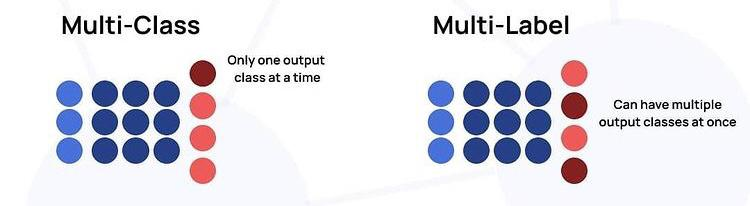
Image source: Analytics Vidhya


<div style="border-radius: 10px; border: #DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size: 100%; text-align: left">
<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>
In our case, the dataset involves a multi-label problem where we are specifically asked to predict the first two features (EC1 and EC2). 
    
Therefore, we need to classify the labels into three categories: EC1, EC2, and others. This is because each data point can belong to both EC1 and EC2 simultaneously. 

By utilizing the multi-label approach, we can accurately predict the membership of each data point in EC1, EC2, or other classes.

In [5]:
# delete columns from EC3 to EC6 + id
train.drop(['id','EC3', 'EC4', 'EC5', 'EC6'], axis=1, inplace=True)

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def f_importance_plot(f_imp):
    fig = plt.figure(figsize=(12, 0.20*len(f_imp)))
    plt.title('Feature importances', size=16, y=1.05, 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', 
                    palette='YlOrBr_r', linestyle="-", 
                    linewidth=0.5, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.tight_layout()
    plt.show()
    
def show_confusion_roc(preds: np.array, target: np.array) -> None:
    f, ax = plt.subplots(1, 2, figsize=(13.3, 4))
    df = pd.DataFrame({'preds': preds, 'target': target})
    cm = confusion_matrix(df.target, df.preds.ge(0.5).astype(int))
    cm_display = ConfusionMatrixDisplay(cm).plot(cmap='YlOrBr_r', ax=ax[0])
    ax[0].grid(False)
    RocCurveDisplay.from_predictions(df.target, df.preds, color='#20BEFF', ax=ax[1])
    plt.tight_layout()
    
def get_mean_auc(oof, target):
    mean_val_auc = roc_auc_score(train[target], oof)
    return mean_val_auc

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* I will now run the XGBoost (XGB), CatBoost (CatBoost), and LightGBM (LGBM) models with basic hyperparameter settings using k-fold cross-validation. To improve performance, hyperparameter tuning is required. However, for the purpose of illustration, I have created a simple code.

> #### modeling - XGB & Catboost & LGBM

In [8]:
# Target columns
target_cols = ['EC1', 'EC2']

# Features
features = ['BertzCT', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3v', 'Chi4n',
            'EState_VSA1', 'EState_VSA2', 'ExactMolWt', 'FpDensityMorgan1',
            'FpDensityMorgan2', 'FpDensityMorgan3', 'HallKierAlpha',
            'HeavyAtomMolWt', 'Kappa3', 'MaxAbsEStateIndex', 'MinEStateIndex',
            'NumHeteroatoms', 'PEOE_VSA10', 'PEOE_VSA14', 'PEOE_VSA6', 'PEOE_VSA7',
            'PEOE_VSA8', 'SMR_VSA10', 'SMR_VSA5', 'SlogP_VSA3', 'VSA_EState9',
            'fr_COO', 'fr_COO2']
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Create models for each target
models = {
    'xgb': {target: XGBClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, eta=0.2, colsample_bytree=0.67,early_stopping_rounds=300) for target in target_cols},
    'lgb': {target: LGBMClassifier(n_estimators=1000, n_jobs=-1, max_depth=4, learning_rate=0.2, colsample_bytree=0.67) for target in target_cols},
    'cat': {target: CatBoostClassifier(n_estimators=1000, depth=4, learning_rate=0.2, verbose=0) for target in target_cols}
}

In [9]:
models

{'xgb': {'EC1': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.67, early_stopping_rounds=300,
                enable_categorical=False, eta=0.2, eval_metric=None,
                feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
                importance_type=None, interaction_constraints=None,
                learning_rate=None, max_bin=None, max_cat_threshold=None,
                max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
                max_leaves=None, min_child_weight=None, missing=nan,
                monotone_constraints=None, n_estimators=1000, n_jobs=-1,
                num_parallel_tree=None, predictor=None, ...),
  'EC2': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=0.67, early_stopping_rounds=300,
                enable_cate

In [10]:
# Dictionaries to store results
oof = {model: {target: [] for target in target_cols} for model in models.keys()}
auc_scores = {model: {target: [] for target in target_cols} for model in models.keys()}
best_iters = {model: {target: [] for target in target_cols} for model in models.keys()}
best_models = {model: {target: None for target in target_cols} for model in models.keys()}
best_auc = {model: {target: 0 for target in target_cols} for model in models.keys()}

In [11]:
oof

{'xgb': {'EC1': [], 'EC2': []},
 'lgb': {'EC1': [], 'EC2': []},
 'cat': {'EC1': [], 'EC2': []}}

In [12]:
for model_name, model_dict in models.items():
    print(model_dict['EC1'])
    break
features

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.67, early_stopping_rounds=300,
              enable_categorical=False, eta=0.2, eval_metric=None,
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=1000, n_jobs=-1,
              num_parallel_tree=None, predictor=None, ...)


['BertzCT',
 'Chi1',
 'Chi1n',
 'Chi1v',
 'Chi2n',
 'Chi2v',
 'Chi3v',
 'Chi4n',
 'EState_VSA1',
 'EState_VSA2',
 'ExactMolWt',
 'FpDensityMorgan1',
 'FpDensityMorgan2',
 'FpDensityMorgan3',
 'HallKierAlpha',
 'HeavyAtomMolWt',
 'Kappa3',
 'MaxAbsEStateIndex',
 'MinEStateIndex',
 'NumHeteroatoms',
 'PEOE_VSA10',
 'PEOE_VSA14',
 'PEOE_VSA6',
 'PEOE_VSA7',
 'PEOE_VSA8',
 'SMR_VSA10',
 'SMR_VSA5',
 'SlogP_VSA3',
 'VSA_EState9',
 'fr_COO',
 'fr_COO2']

In [14]:
# Training parameters
FOLDS = 5
SEED = 1004
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

# Train models
for model_name, model_dict in models.items():
    print(f'\033[1;34mTraining {model_name} models\033[0m')  # Blue for model names
    for target in target_cols:
        print(f'\033[1;32mTraining model for {target}\033[0m')  # Green for targets
        y = train[target]
        for fold, (train_idx, val_idx) in enumerate(skf.split(train, y)):
            print(f'\033[1;33m######################## Training FOLD {fold+1} ########################\033[0m')  # Yellow for fold numbers
            X_train, y_train = train.iloc[train_idx][features], y.iloc[train_idx]
            X_valid, y_valid = train.iloc[val_idx][features], y.iloc[val_idx]
            model = model_dict[target]
#             model.set_params(early_stopping_rounds=300)
            model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=0)
            val_preds = model.predict_proba(X_valid)[:, 1]
            val_score = roc_auc_score(y_valid, val_preds)
            print(f'\033[1;35mauc: {val_score:.5f}\033[0m')  # Purple for AUC scores
            oof[model_name][target].append(val_preds)
            auc_scores[model_name][target].append(val_score)
            if model_name == 'xgb':  # XGBoost
                best_iters[model_name][target].append(model.get_booster().best_ntree_limit)
            elif model_name == 'lgb':  # LightGBM
                best_iters[model_name][target].append(model.best_iteration_)
            # Save the best model
            if val_score > best_auc[model_name][target]:
                best_auc[model_name][target] = val_score
                best_models[model_name][target] = model
        print(f'\033[1;31m*********************************************\033[0m')  # Red for separator
        print(f'\033[1;35mMean AUC for {target}: {np.mean(auc_scores[model_name][target]):.5f}\033[0m')  # Purple for mean AUC scores

Training xgb models
Training model for EC1
######################## Training FOLD 1 ########################
auc: 0.70508
######################## Training FOLD 2 ########################
auc: 0.70517
######################## Training FOLD 3 ########################
auc: 0.69498
######################## Training FOLD 4 ########################
auc: 0.69834
######################## Training FOLD 5 ########################
auc: 0.71087
*********************************************
Mean AUC for EC1: 0.70289
Training model for EC2
######################## Training FOLD 1 ########################
auc: 0.55953
######################## Training FOLD 2 ########################
auc: 0.57891
######################## Training FOLD 3 ########################
auc: 0.59910
######################## Training FOLD 4 ########################
auc: 0.58715
######################## Training FOLD 5 ########################
auc: 0.58321
*********************************************
Mean AUC for EC2: 0.58158


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.66883
######################## Training FOLD 2 ########################


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.66547
######################## Training FOLD 3 ########################


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.64597
######################## Training FOLD 4 ########################


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.64886
######################## Training FOLD 5 ########################


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.67447
*********************************************
Mean AUC for EC1: 0.66072
Training model for EC2
######################## Training FOLD 1 ########################


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.52789
######################## Training FOLD 2 ########################


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.53801
######################## Training FOLD 3 ########################


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.56872
######################## Training FOLD 4 ########################


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.51547
######################## Training FOLD 5 ########################


/Volumes/TAPPS/DS_APPS/anaconda3/envs/tensorflow/lib/python3.9/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


auc: 0.51962
*********************************************
Mean AUC for EC2: 0.53394
Training cat models
Training model for EC1
######################## Training FOLD 1 ########################
auc: 0.70619
######################## Training FOLD 2 ########################
auc: 0.70595
######################## Training FOLD 3 ########################
auc: 0.69447
######################## Training FOLD 4 ########################
auc: 0.69445
######################## Training FOLD 5 ########################
auc: 0.71260
*********************************************
Mean AUC for EC1: 0.70273
Training model for EC2
######################## Training FOLD 1 ########################
auc: 0.57441
######################## Training FOLD 2 ########################
auc: 0.58784
######################## Training FOLD 3 ########################
auc: 0.60006
######################## Training FOLD 4 ########################
auc: 0.57986
######################## Training FOLD 5 ########################


### <p style="font-family:JetBrains Mono; font-weight:bold; letter-spacing: 2px; color:#006600; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid #003300">🏁 Evaluation and Conclusion</p>

In [15]:
auc_df = pd.DataFrame(auc_scores)

auc_df = auc_df.applymap(np.mean)
styled_auc_df = auc_df.style.format("{:.4f}").background_gradient(cmap='YlOrBr_r')

display(styled_auc_df)


,xgb,lgb,cat
EC1,0.7029,0.6607,0.7027
EC2,0.5816,0.5339,0.5840


Visualization for xgb EC1


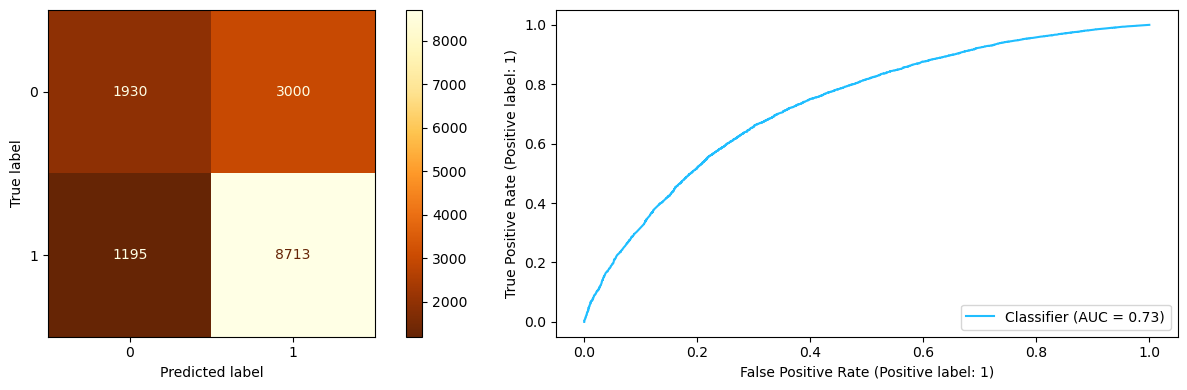

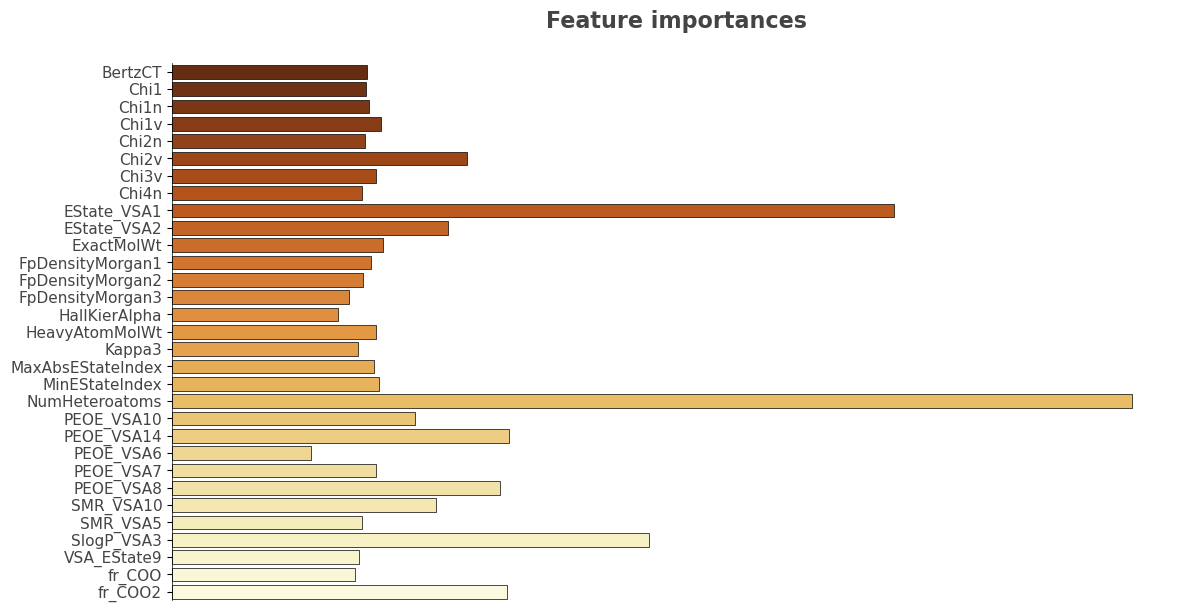

Visualization for xgb EC2


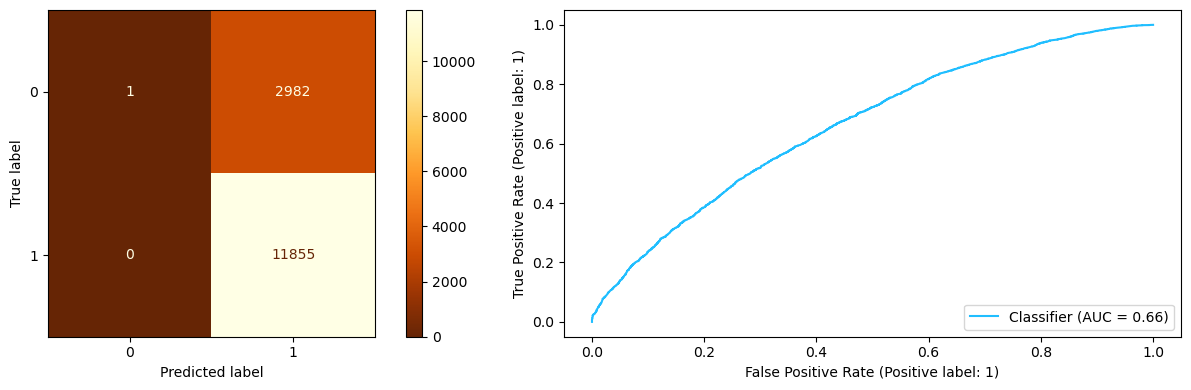

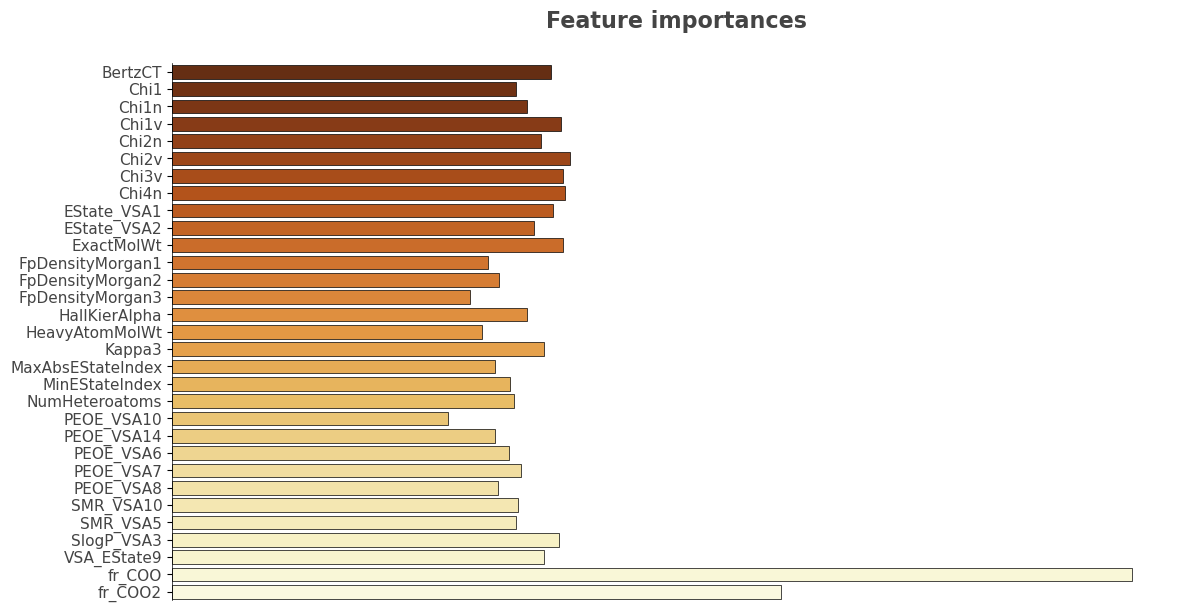

Visualization for lgb EC1


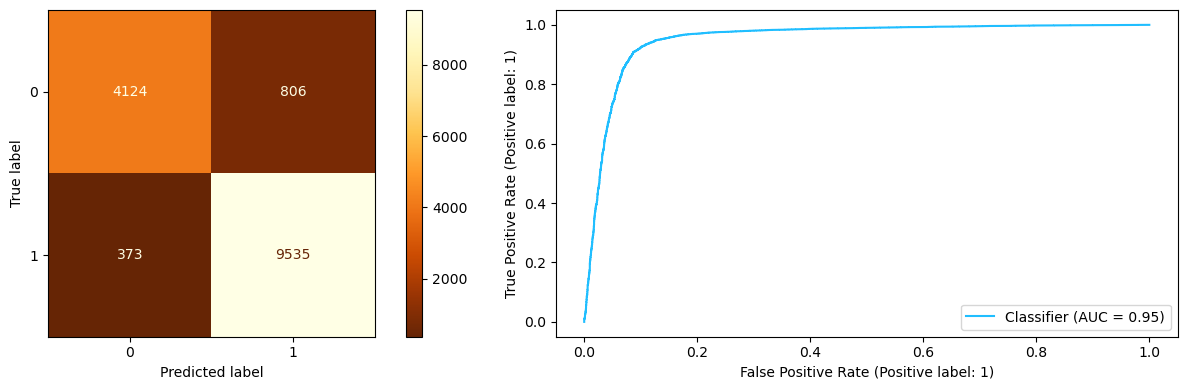

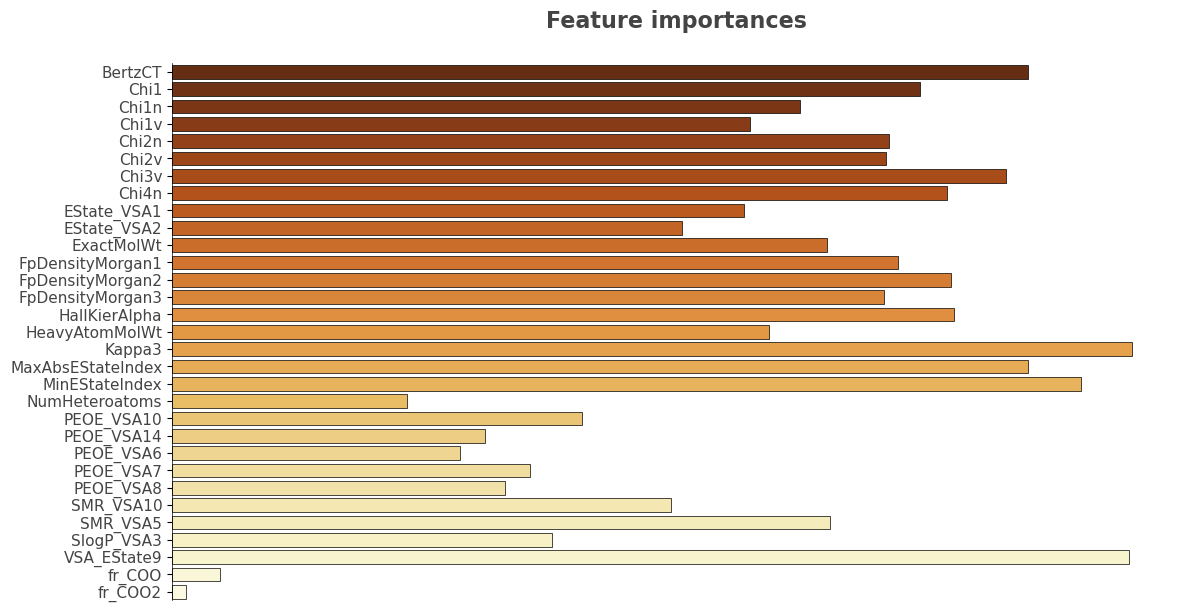

Visualization for lgb EC2


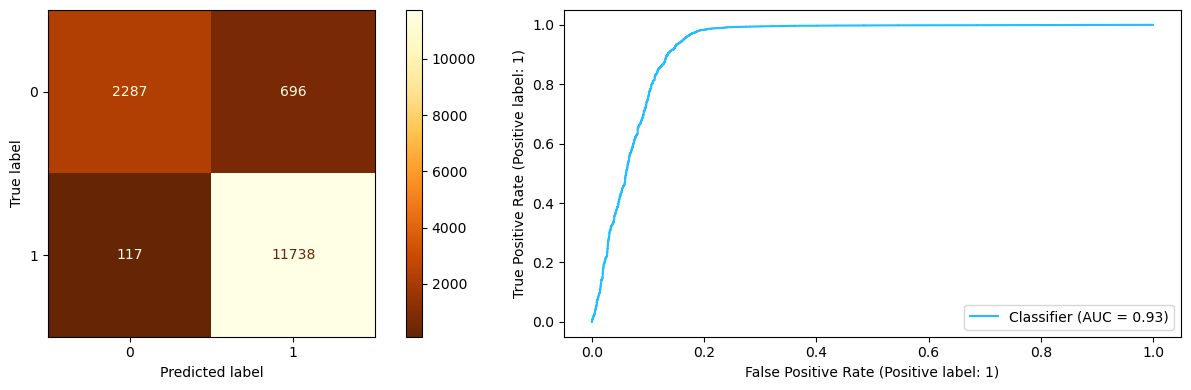

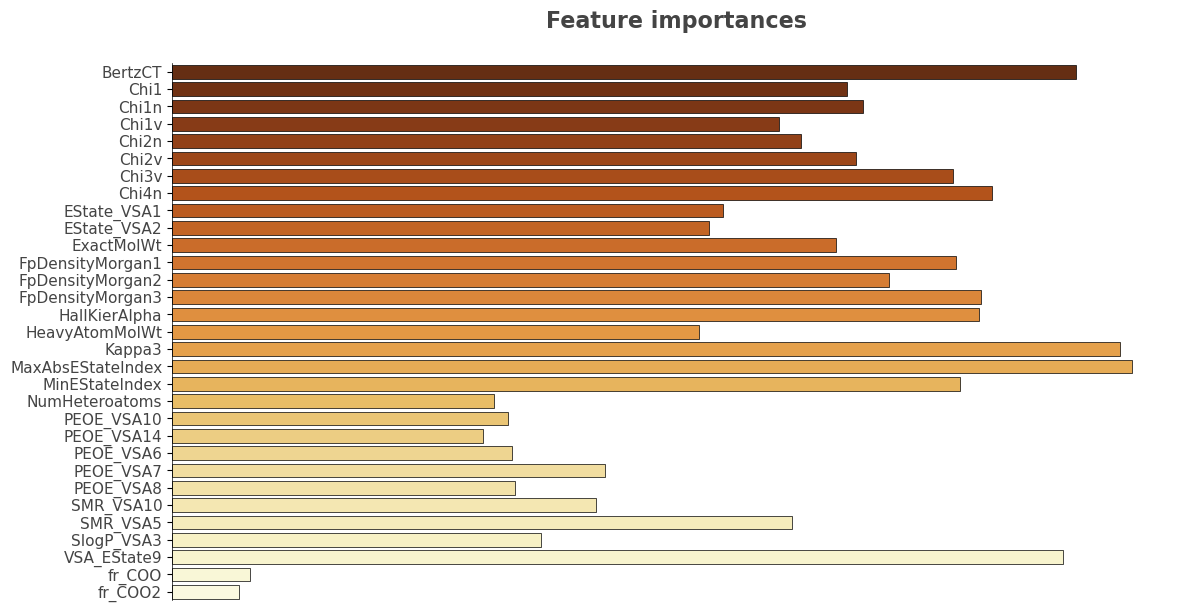

Visualization for cat EC1


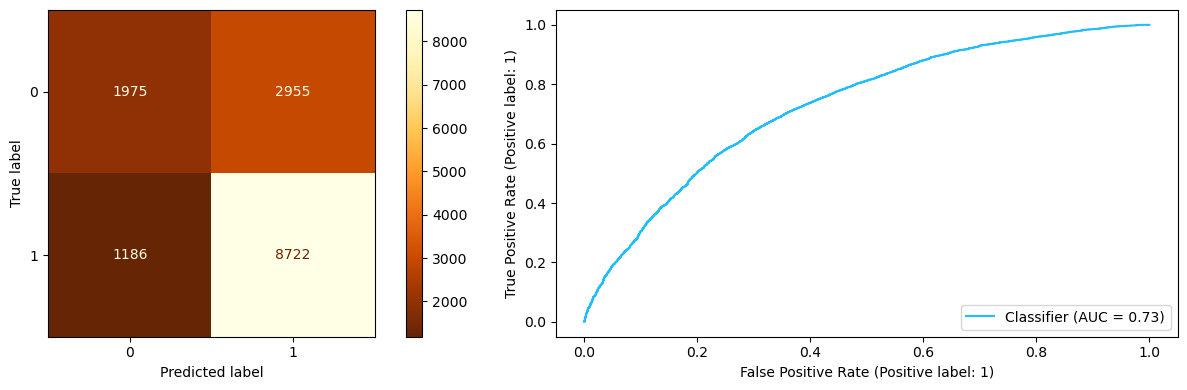

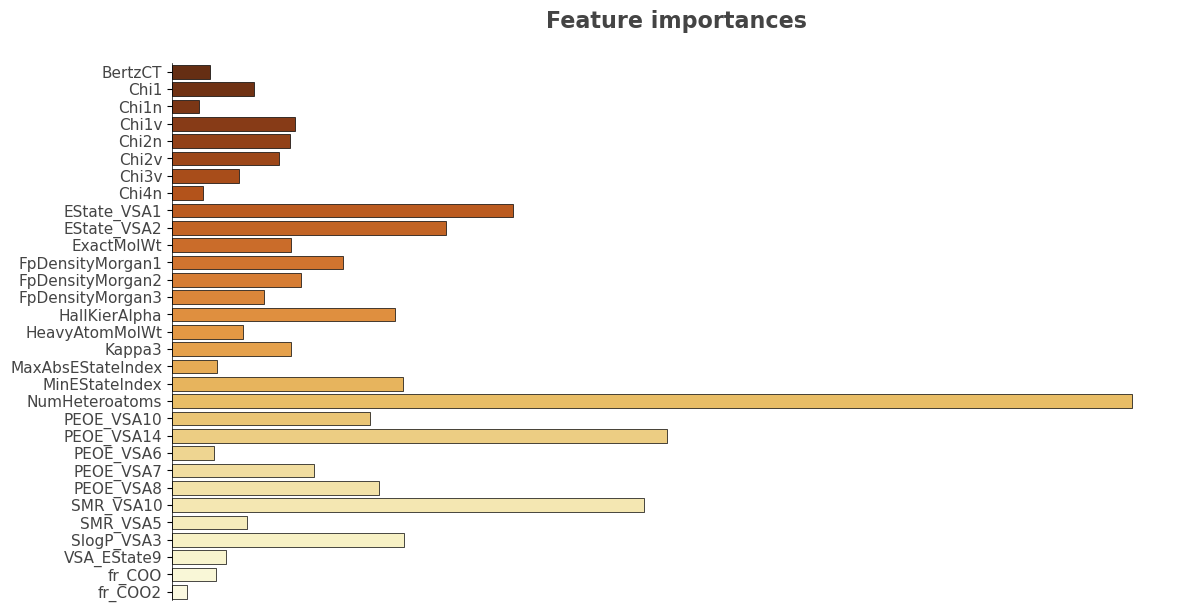

Visualization for cat EC2


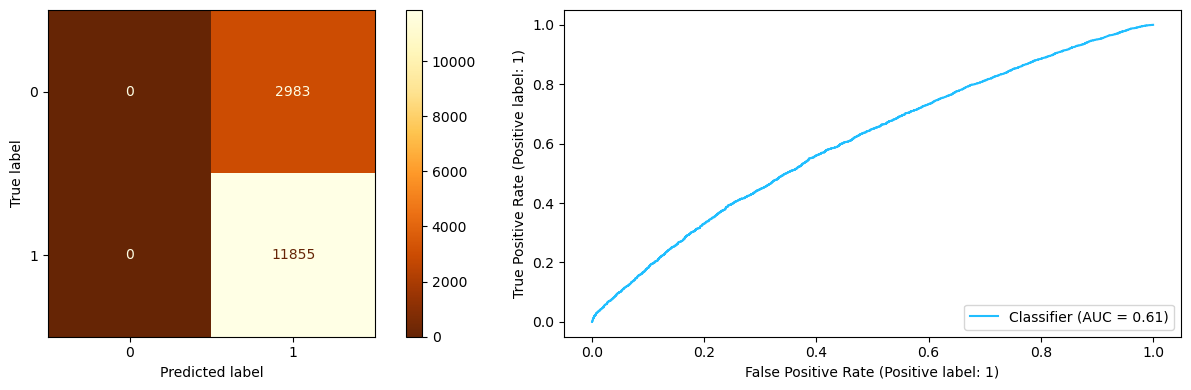

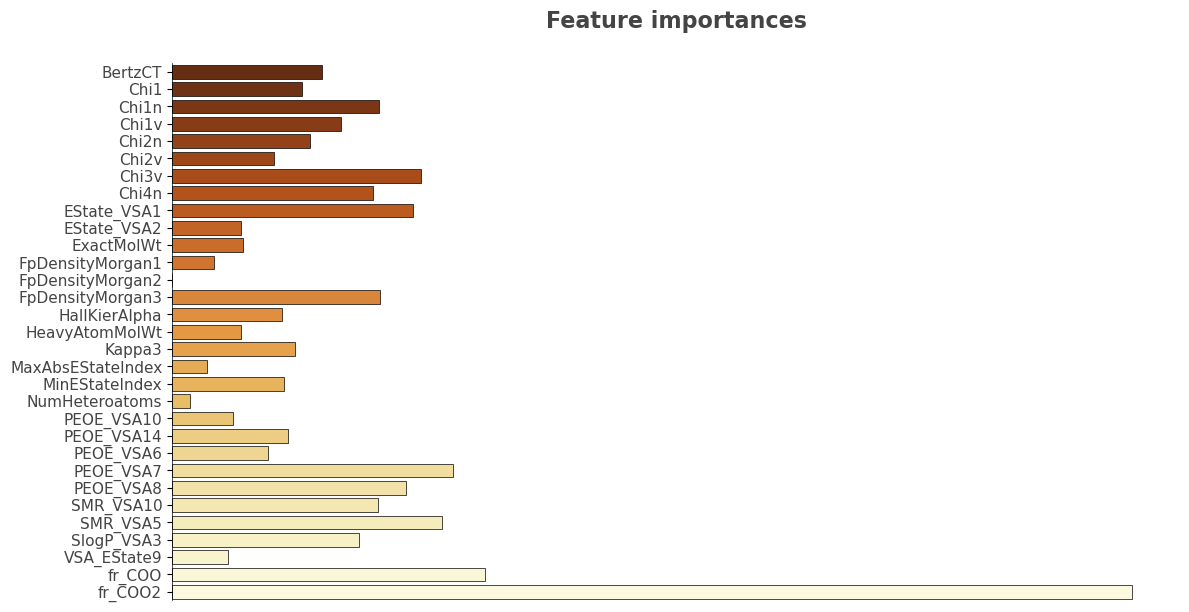

In [16]:
for model_name, model_dict in best_models.items():
    for target in target_cols:
        print(f'\033[1;34;4mVisualization for {model_name} {target}\033[0m')  # Blue with underline for model and target
        best_val_preds = model_dict[target].predict_proba(train[features])[:, 1]
        show_confusion_roc(best_val_preds, train[target])
        f_imp_df = pd.DataFrame({'feature': features, 'avg_imp': model_dict[target].feature_importances_})
        f_importance_plot(f_imp_df)


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Notes:</font></h3>

* The EC1 model performs better than the EC2 model, even though the class distribution between EC1 and EC2 is not significantly different, and EC2 has a larger number of instances. This suggests that the difference in performance is likely due to the influence of the features. Therefore, I encourage you to explore feature engineering techniques to improve the performance of the models.
    
* Additionally, it is important to note that the feature importance varies across the models. This indicates that considering a stacking model, such as an ensemble that combines the predictions of multiple models, may be worth exploring. This can potentially further enhance the predictive performance by leveraging the diverse feature importance patterns of the individual models.

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">

<h3 align="left"><font color='#DEB887'>💡 Conclusion:</font></h3>

* I skipped detailed feature engineering and hyper-parameter tuning, which could enhance model performance.

* You can apply this template to almost every multi-label classification problem.

In [17]:
test.head(3)

,id,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,14838,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,14839,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,14840,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1


In [19]:
X_test=test[features]
X_test.head(3)

,BertzCT,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3v,Chi4n,EState_VSA1,EState_VSA2,...,PEOE_VSA14,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,SMR_VSA10,SMR_VSA5,SlogP_VSA3,VSA_EState9,fr_COO,fr_COO2
0,344.632371,7.283603,4.473966,5.834958,3.412257,4.651530,2.096558,1.116433,49.458581,0.000000,...,13.512441,0.000000,0.000000,0.000000,26.809272,24.539800,4.794537,47.304082,1,1
1,1432.410201,10.663869,7.079026,8.065215,5.297097,5.297097,3.924155,2.569694,0.000000,29.783175,...,0.000000,34.947374,98.323987,9.606882,0.000000,53.378235,0.000000,43.166667,0,0
2,83.352608,3.931852,1.774215,1.774215,1.073446,1.073446,0.467830,0.170838,5.969305,6.420822,...,5.969305,0.000000,0.000000,6.420822,11.752550,13.344559,9.589074,24.666667,1,1


In [ ]:
val_preds = model.predict_proba(X_valid)[:, 1]

In [24]:
model=models['xgb']['EC1']
preds1=model.predict(X_test)

In [25]:
preds1

array([0, 1, 1, ..., 0, 0, 0])

In [26]:
model2=models['cat']['EC2']
preds2=model2.predict(X_test)
preds2

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
sum(preds2),len(preds2)

(9893, 9893)

### Submission

In [30]:
import subprocess
compe='playground-series-s3e18'
def make_sub(pred_y1,pred_y2,df_test=test,name='default'):
    df_submission = pd.DataFrame()
    df_submission['id']=df_test['id']
    df_submission['EC1']=pred_y1
    df_submission['EC2']=pred_y2
    df_submission.to_csv(f'submission-{name}.csv', index=False)
    cmd =f'kaggle competitions submit -c {compe} -f submission-{name}.csv -m "Message"'
    subprocess.run(cmd, shell=True)
    print(f'succesully saved - {name}')

In [31]:
make_sub(preds1,preds2,name='cat_lgb')

100%|██████████| 96.6k/96.6k [00:01<00:00, 97.1kB/s]


Successfully submitted to Explore Multi-Label Classification with an Enzyme Substrate Datasetsuccesully saved - cat_lgb
